# Ahnen Method ON/OFF Analysis
#### July 2021

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import frompyfunc, arange
from scipy.optimize import fminbound
from mpmath import (hyperu, mp, sqrt, pi, atan, hyp2f1, gamma,
    erfinv, rgamma, exp, power, quad, findroot, power)
# set a sufficiently good accuracy for mpmath
mp.dps = 50

In [29]:
def B_01(Non, Noff, alpha):
    '''
    define Bayes factor, meaning the odds of background hypothesis over the
    signal hypothesis.
    
    I realized that it may be better to drop one of the assumptions from the paper 
    ( that there is a full set of mutually exclusive hypothesis ) and work with 
    the Bayes factor directly. The implications of that are negligible when deciding 
    if there is a detection or not, as the missing gamma is small compared to delta 
    in the case of a signal.
    '''
    # gamma, delta, c1/c2
    Nges = Non + Noff
    gam = (1 + 2 * Noff) * power(alpha,(0.5 + Nges)) * gamma(0.5 + Nges)
    delta = (2 * power((1 + alpha),Nges)) * gamma(1+Nges) * hyp2f1(0.5 + Noff, 1 + Nges, 1.5 + Noff, (-1 / alpha))
    c1_c2 = sqrt(pi) / (2 * atan(1 / sqrt(alpha)))

    return gam / (c1_c2 * delta)

def P_lambda(lambda_s, Non, Noff, alpha):
    '''
    This is the marginalized signal parameter posterior.
    The method is vectorized, in order to plot it faster (with matplotlib).
    '''
    # make a vectoriyed version of hyperu
    hyperu_vec = frompyfunc(hyperu, 3, 1)
    exp_vec = frompyfunc(exp, 1, 1)
    power_vec = frompyfunc(power, 2, 1)
    # rgamma_vec = frompyfunc(rgamma,1,1)

    n1 = Non + Noff
    n2 = Noff + 0.5
    n3 = n1 + 1
    n4 = n2 + 1

    buf1 = exp_vec(-lambda_s) * power_vec(lambda_s, n1) * rgamma(n1 + 1)
    buf2 = hyperu_vec(n2, n3, lambda_s * (1. + 1. / alpha))
    buf3 = hyp2f1(n2, n3, n4, (-1. / alpha)) * rgamma(n4)

    # print(buf1, buf2, buf3)

    return 1./buf3*buf1*buf2

def C_lambda(
        lambda_s,
        Non,
        Noff,
        alpha,
        maxdeg=4,
        err=True,
        meth='gauss-legendre',
        ):
    '''
    The cumulative distribution function of the signal posterior.
    It uses Gauss-Legendre quadrature (optionally whatever mpmath.quad
    can offer), in order to calculate the definite integral on the
    interval [0,lambda_s].
    '''
    return quad(
        lambda x: P_lambda(x, Non, Noff, alpha),
        [0, lambda_s],
        maxdegree=maxdeg,
        error=err,
        method=meth)

def l_99(Non, Noff, alpha):
    '''
    this function shall find the 99% signal
    posterior UL using the secant method and a good guess of the
    starting point '''
    sigma = sqrt(alpha*alpha*Noff + Non)
    lstar = 0.0-alpha*Noff+Non

    # lmin = 1e-11 if (lstar - sigma) < 0 else (lstar - sigma)
    lmax = 1e-11 if (lstar + 2*sigma) < 0 else (lstar + 2*sigma)
    guess = 3. + lmax
    # print(guess)

    b = findroot(
        lambda x: C_lambda(x, Non, Noff, alpha)[0]-0.99,
        guess,
        solver='secant',
        tol=1e-8)
    return b

def l_97(Non, Noff, alpha):
    '''
    this function shall find the 99% signal
    posterior UL using the secant method and a good guess of the
    starting point '''
    sigma = sqrt(alpha*alpha*Noff + Non)
    lstar = 0.0-alpha*Noff+Non

    # lmin = 1e-11 if (lstar - sigma) < 0 else (lstar - sigma)
    lmax = 1e-11 if (lstar + 2*sigma) < 0 else (lstar + 2*sigma)
    guess = 3. + lmax
    # print(guess)

    b = findroot(
        lambda x: C_lambda(x, Non, Noff, alpha)[0]-0.9772,
        guess,
        solver='secant',
        tol=1e-8)
    return b

def S_B_01(Non, Noff, alpha):
    '''
    calculate the bayesian z-value via the bayes factor, truncated
    to a reasonable number count region
    '''
    buf = 1-B_01(Non, Noff, alpha)
    if buf < -1.0:
        buf = -1.0
    # print(buf)
    return sqrt("2")*erfinv(buf)

## FOXSI2 Values

In [36]:
Nons = [10, 13, 9, 10]
Noffs = [4, 3, 1, 1]
Alphas = [0.859, 0.920, 0.872, 0.869]

In [59]:
Bs, Ss,L97s = [], [], []
for n_on, n_off, alpha in zip(Nons,Noffs,Alphas):
    Bs.append(float(B_01(n_on, n_off, alpha)))
    Ss.append(float(S_B_01(n_on, n_off, alpha)))
    L97s.append(float(l_97(n_on, n_off, alpha)))

In [60]:
print(np.array(Bs))
print(np.array(Ss))
print(np.array(L97s))

[0.06224102 0.00826268 0.00547865 0.00277371]
[1.86457488 2.64114325 2.77745435 2.99176406]
[14.73252028 19.08851532 15.51650496 16.83080483]


#### Plot

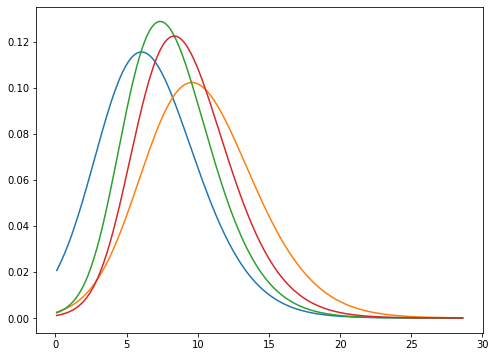

In [67]:
# plot the pdf
x_range = arange(0, 1.5 * np.max(L97s), 0.1)
fig, ax = plt.subplots(figsize=(8,6))
for n_on, n_off, alpha in zip(Nons,Noffs,Alphas):
    y_range = P_lambda(x_range, n_on, n_off, alpha)
    ax.plot(x_range, y_range)

plt.show()